In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
#import paths_cpt
import data_processing as dp
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report
from tqdm import tqdm

cpt_data = pd.read_parquet("../data/vw_cpt_brussels_params_completeset_20250318_remapped.parquet",  engine="fastparquet")

Parameters:
  EXTRACT_TREND: True
  BIN_W: 0.6
  SET_SEED: 100
  EXTRACT_TREND_TYPE: multiplicative


In [2]:
cpt_data.head()

,sondering_id,index,pkey_sondering,sondeernummer,x,y,start_sondering_mtaw,diepte_sondering_tot,diepte,diepte_mtaw,qc,fs,qtn,rf,fr,icn,sbt,ksbt,lithostrat_id
0,314,2593,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.6,13.66,1.17,0.035,35.894004,2.991453,3.058371,2.564340,5.0,1.434000e-07,Quartair
1,314,2594,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.7,13.56,1.57,0.033,42.562319,2.101911,2.138968,2.406724,5.0,4.321000e-07,Quartair
2,314,2595,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.8,13.46,1.43,0.036,38.536991,2.517483,2.569226,2.491219,5.0,2.392000e-07,Quartair
3,314,2596,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.9,13.36,0.50,0.024,15.678501,4.800000,5.111166,2.982185,3.0,7.700000e-09,Quartair
4,314,2597,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,2.0,13.26,1.33,0.023,33.203119,1.729323,1.772110,2.440158,5.0,3.419000e-07,Quartair


In [3]:
print("Rows, cols:", cpt_data.shape)
print("Columns:", cpt_data.columns.tolist())

Rows, cols: (1220548, 19)
Columns: ['sondering_id', 'index', 'pkey_sondering', 'sondeernummer', 'x', 'y', 'start_sondering_mtaw', 'diepte_sondering_tot', 'diepte', 'diepte_mtaw', 'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt', 'lithostrat_id']


In [4]:
# Keep only rows with valid lithostratigraphic labels
cpt_data = cpt_data[cpt_data["lithostrat_id"].notna()].copy()

print("Filtered dataset shape:", cpt_data.shape)
print("Unique lithostrat units:", cpt_data["lithostrat_id"].nunique())

Filtered dataset shape: (267174, 19)
Unique lithostrat units: 35


In [5]:
# Parameters
BIN_W = 0.6
EXTRACT_TREND = True
TREND_TYPE = "multiplicative"
SEED = 42

# Split Train/Test IDs
print("Splitting data into train and test sets...")
# pass the dataframe to group_strat_split. 
# It expects columns: "sondering_id", "lithostrat_id"
# split_res = dp.group_strat_split(cpt_data, prop=0.7, tol=0.05, seed=SEED)
# train_ids = split_res["train_ids"]
# test_ids = split_res["test_ids"]


import json
with open("../results/split_res.json", "r") as f:
    split_res = json.load(f)
train_ids = set(split_res["train_ids"])
test_ids = set(split_res["test_ids"])
print(list(test_ids)[1:5])

print(f"Train IDs: {len(train_ids)}")
print(f"Test IDs: {len(test_ids)}")

# Process Train and Test Data Separately
print("Processing training data...")
train_processed = dp.process_test_train(
    cpt_df=cpt_data,
    sondering_ids=train_ids,
    bin_w=BIN_W,
    do_extract_trend=EXTRACT_TREND,
    trend_type=TREND_TYPE
)

print("Processing test data...")
test_processed = dp.process_test_train(
    cpt_df=cpt_data,
    sondering_ids=test_ids,
    bin_w=BIN_W,
    do_extract_trend=EXTRACT_TREND,
    trend_type=TREND_TYPE
)

print("Train processed shape:", train_processed.shape)
print("Test processed shape:", test_processed.shape)

Splitting data into train and test sets...
[4640, 4643, 4648, 1580]
Train IDs: 200
Test IDs: 86
Processing training data...


/home/mburu/projects/uhasselt/CPT_usecase/modeling/data_processing.py:276: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_trend_and_fill))
/home/mburu/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mburu/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Processing test data...


/home/mburu/projects/uhasselt/CPT_usecase/modeling/data_processing.py:276: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_trend_and_fill))
/home/mburu/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mburu/miniconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Train processed shape: (6151, 188)
Test processed shape: (2528, 188)


In [6]:
## save raw test data as csv
test_raw = cpt_data[cpt_data["sondering_id"].isin(test_ids)]
test_raw.to_csv("../data/test_raw_data.csv", index=False)

In [7]:
# print head of train 
train_processed.head()

,sondering_id,depth_bin,qc_sd,fs_sd,rf_sd,qtn_sd,fr_sd,diepte_sd,diepte_mtaw_sd,qc_mean,...,diepte_whole_valid_n,diepte_mtaw_whole_valid_n,diepte_whole_frac_missing,diepte_mtaw_whole_frac_missing,lithostrat_id,qc_frac_gt20,qc_frac_gt40,qc_count_gt20,qc_count_gt40,qc_p99
0,315,"(1.2, 1.8]",0.341885,0.007219,0.215849,7.997370,0.213936,0.129099,0.129099,4.341948,...,240.0,240.0,0.0,0.0,Quartair,0.0,0.0,0.0,0.0,3.6158
1,315,"(1.8, 2.4]",0.530746,0.012353,0.412248,13.273318,0.428881,0.216025,0.216025,2.915270,...,240.0,240.0,0.0,0.0,Quartair,0.0,0.0,0.0,0.0,4.8886
2,315,"(2.4, 3.0]",0.342887,0.006013,0.480644,7.434536,0.491487,0.187083,0.187083,1.184833,...,240.0,240.0,0.0,0.0,Quartair,0.0,0.0,0.0,0.0,1.0665
3,315,"(3.0, 3.6]",0.115977,0.002752,1.045743,1.744258,1.182222,0.158114,0.158114,0.874000,...,240.0,240.0,0.0,0.0,Quartair,0.0,0.0,0.0,0.0,1.3744
4,315,"(3.6, 4.2]",0.484236,0.004841,0.998556,7.088877,1.138466,0.216025,0.216025,2.028571,...,240.0,240.0,0.0,0.0,Quartair,0.0,0.0,0.0,0.0,3.7082


In [8]:
# head of test
test_processed.head()

,sondering_id,depth_bin,qc_sd,fs_sd,rf_sd,qtn_sd,fr_sd,diepte_sd,diepte_mtaw_sd,qc_mean,...,diepte_whole_valid_n,diepte_mtaw_whole_valid_n,diepte_whole_frac_missing,diepte_mtaw_whole_frac_missing,lithostrat_id,qc_frac_gt20,qc_frac_gt40,qc_count_gt20,qc_count_gt40,qc_p99
0,314,"(1.2, 1.8]",0.020355,0.000424,0.629001,0.768622,0.650116,0.070711,0.070711,1.871289,...,239.0,239.0,0.0,0.0,Quartair,0.0,0.0,0.0,0.0,1.5660
1,314,"(1.8, 2.4]",0.100368,0.001635,1.274885,2.863361,1.375155,0.216025,0.216025,1.698995,...,239.0,239.0,0.0,0.0,Quartair,0.0,0.0,0.0,0.0,2.2046
2,314,"(2.4, 3.0]",0.186748,0.001380,0.365309,4.393847,0.372325,0.187083,0.187083,1.639667,...,239.0,239.0,0.0,0.0,Quartair,0.0,0.0,0.0,0.0,1.7575
3,314,"(3.0, 3.6]",0.106500,0.002760,1.633421,2.370866,2.122284,0.158114,0.158114,1.143800,...,239.0,239.0,0.0,0.0,Quartair,0.0,0.0,0.0,0.0,1.9080
4,314,"(3.6, 4.2]",0.099661,0.002709,1.012828,2.390063,1.117128,0.216025,0.216025,0.687500,...,239.0,239.0,0.0,0.0,Quartair,0.0,0.0,0.0,0.0,2.0426


In [9]:
# Imports for Modeling
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, GroupKFold
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix, make_scorer, log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Segments of Interest
segments_oi = [
    "Quartair", "Diest", "Bolderberg", "Sint_Huibrechts_Hern", "Ursel",
    "Asse", "Wemmel", "Lede", "Brussel", "Merelbeke", "Kwatrecht",
    "Mont_Panisel", "Aalbeke", "Mons_en_Pevele"
]

# Filter Data
# use the processed dataframes
train_df = train_processed[train_processed["lithostrat_id"].isin(segments_oi) & (train_processed["lithostrat_id"] != "Onbekend")].copy()
test_df = test_processed[test_processed["lithostrat_id"].isin(segments_oi) & (test_processed["lithostrat_id"] != "Onbekend")].copy()

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

# Features & Targets
exclude_cols = ["sondering_id", "lithostrat_id", "depth_bin", "diepte", "QC_raw"]
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
y_train = train_df["lithostrat_id"]
X_test = test_df[feature_cols]
y_test = test_df["lithostrat_id"]

# Encoding
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("Classes:", le.classes_)

# Preprocessing Pipeline
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('var_thresh', VarianceThreshold(threshold=0))
])

# Helper for plotting
def plot_confusion_matrix(y_true, y_pred, classes, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Train shape: (5477, 188)
Test shape: (2312, 188)
Classes: ['Aalbeke' 'Asse' 'Bolderberg' 'Brussel' 'Diest' 'Kwatrecht' 'Lede'
 'Merelbeke' 'Mons_en_Pevele' 'Mont_Panisel' 'Quartair'
 'Sint_Huibrechts_Hern' 'Ursel' 'Wemmel']


In [10]:
# XGBoost Training
print("Training XGBoost...")
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, n_jobs=1))
])

xgb_params = {
    "classifier__n_estimators": [300, 500, 700],
    "classifier__max_depth": [20, 30, 60],
    "classifier__learning_rate": [0.01, 0.05],
    "classifier__subsample": [0.7, 0.9]
}

gkf = GroupKFold(n_splits=5)
sondering_groups = train_df["sondering_id"]

all_labels = list(range(len(le.classes_)))
custom_log_loss = make_scorer(
    log_loss, 
    greater_is_better=False, 
     response_method="predict_proba",
    labels=all_labels
)


xgb_search = RandomizedSearchCV(
    xgb_pipeline, 
    param_distributions=xgb_params,
    n_iter=1, 
    cv= gkf ,
    scoring= custom_log_loss,
    n_jobs=10,
    random_state=SEED
)

xgb_search.fit(X_train, y_train_enc, groups=sondering_groups)
best_xgb = xgb_search.best_estimator_

print(f"Best XGB Params: {xgb_search.best_params_}")
print(f"Best CV Accuracy: {xgb_search.best_score_:.4f}")

Training XGBoost...


/home/mburu/miniconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [08:09:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mburu/miniconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [08:09:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mburu/miniconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [08:09:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mburu/miniconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [08:09:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/mburu/miniconda3/lib/python3.11/site-packages/

Best XGB Params: {'classifier__subsample': 0.9, 'classifier__n_estimators': 700, 'classifier__max_depth': 60, 'classifier__learning_rate': 0.05}
Best CV Accuracy: -1.2666


XGBoost Classification Report:
                      precision    recall  f1-score   support

             Aalbeke       0.65      0.74      0.69       102
                Asse       0.78      0.51      0.62        63
          Bolderberg       0.00      0.00      0.00        23
             Brussel       0.76      0.78      0.77       420
               Diest       0.94      0.89      0.92        19
           Kwatrecht       0.42      0.41      0.42        34
                Lede       0.65      0.72      0.68       221
           Merelbeke       0.80      0.27      0.40        15
      Mons_en_Pevele       0.69      0.62      0.66       213
        Mont_Panisel       0.75      0.76      0.76       220
            Quartair       0.85      0.87      0.86       799
Sint_Huibrechts_Hern       0.58      0.39      0.47        38
               Ursel       0.55      0.65      0.60        40
              Wemmel       0.59      0.67      0.63       105

            accuracy                 

/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


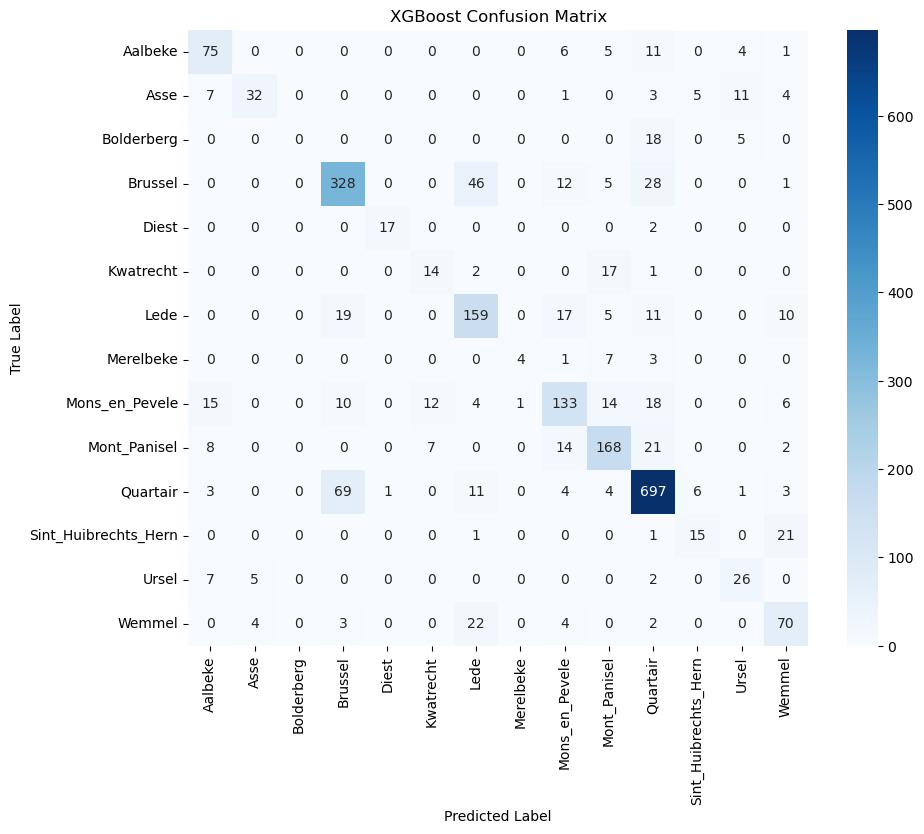

In [11]:
# XGBoost Evaluation
y_pred_xgb = best_xgb.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test_enc, y_pred_xgb, target_names=le.classes_))

plot_confusion_matrix(y_test_enc, y_pred_xgb, le.classes_, title="XGBoost Confusion Matrix")

In [12]:
# Random Forest Training
print("Training Random Forest...")
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight="balanced", n_jobs=1))
])

rf_params = {
    "classifier__n_estimators": [100, 150],
    "classifier__max_features": ["log2"],
    "classifier__min_samples_split": [5, 10, 20]
}

rf_search = RandomizedSearchCV(
    rf_pipeline, 
    param_distributions=rf_params,
    n_iter=1, 
    cv= gkf, 
    scoring= custom_log_loss,
    n_jobs=-1,
    random_state=SEED
)

rf_search.fit(X_train, y_train_enc, groups=sondering_groups)
best_rf = rf_search.best_estimator_

print(f"Best RF Params: {rf_search.best_params_}")
print(f"Best CV Accuracy: {rf_search.best_score_:.4f}")

Training Random Forest...
Best RF Params: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__max_features': 'log2'}
Best CV Accuracy: -1.0669


Random Forest Classification Report:
                      precision    recall  f1-score   support

             Aalbeke       0.68      0.71      0.69       102
                Asse       0.64      0.54      0.59        63
          Bolderberg       0.00      0.00      0.00        23
             Brussel       0.79      0.79      0.79       420
               Diest       1.00      0.79      0.88        19
           Kwatrecht       0.39      0.38      0.39        34
                Lede       0.71      0.80      0.75       221
           Merelbeke       0.60      0.40      0.48        15
      Mons_en_Pevele       0.73      0.76      0.74       213
        Mont_Panisel       0.74      0.77      0.76       220
            Quartair       0.86      0.86      0.86       799
Sint_Huibrechts_Hern       0.52      0.39      0.45        38
               Ursel       0.54      0.62      0.58        40
              Wemmel       0.66      0.64      0.65       105

            accuracy           

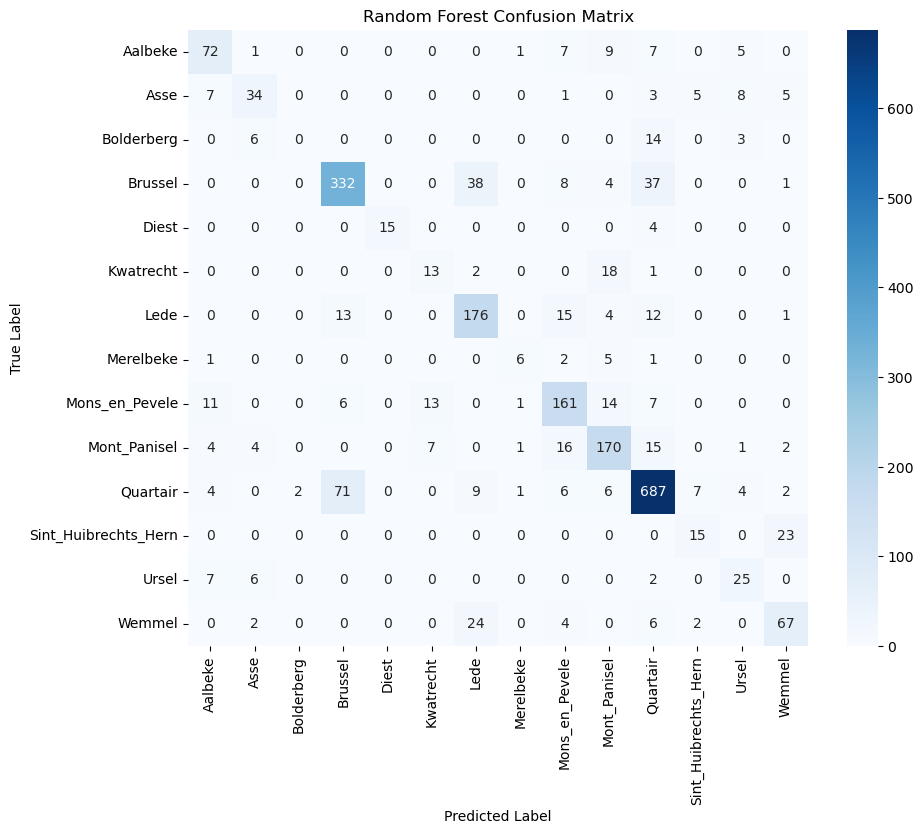

In [13]:
# Random Forest Evaluation
y_pred_rf = best_rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test_enc, y_pred_rf, target_names=le.classes_))

plot_confusion_matrix(y_test_enc, y_pred_rf, le.classes_, title="Random Forest Confusion Matrix")

In [14]:
# LightGBM Training
print("Training LightGBM...")
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(verbose=-1, n_jobs=1))
])

lgbm_params = {
    "classifier__n_estimators": [100, 150],
    "classifier__num_leaves": [60, 90, 120],
    "classifier__learning_rate": [0.01, 0.05, 0.1],
    "classifier__feature_fraction": [0.7, 0.9]
}

lgbm_search = RandomizedSearchCV(
    lgbm_pipeline, 
    param_distributions=lgbm_params,
    n_iter=1, 
    cv= gkf, 
    scoring= custom_log_loss,
    n_jobs=-1,
    random_state=SEED
)

lgbm_search.fit(X_train, y_train_enc, groups=sondering_groups)
best_lgbm = lgbm_search.best_estimator_

print(f"Best LGBM Params: {lgbm_search.best_params_}")
print(f"Best CV Accuracy: {lgbm_search.best_score_:.4f}")

Training LightGBM...


/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warni

Best LGBM Params: {'classifier__num_leaves': 120, 'classifier__n_estimators': 150, 'classifier__learning_rate': 0.1, 'classifier__feature_fraction': 0.9}
Best CV Accuracy: -6.2596


/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Classification Report:
                      precision    recall  f1-score   support

             Aalbeke       0.66      0.76      0.71       102
                Asse       0.71      0.46      0.56        63
          Bolderberg       0.00      0.00      0.00        23
             Brussel       0.75      0.78      0.77       420
               Diest       0.00      0.00      0.00        19
           Kwatrecht       0.39      0.47      0.43        34
                Lede       0.65      0.77      0.71       221
           Merelbeke       0.50      0.33      0.40        15
      Mons_en_Pevele       0.70      0.62      0.66       213
        Mont_Panisel       0.73      0.73      0.73       220
            Quartair       0.85      0.87      0.86       799
Sint_Huibrechts_Hern       0.54      0.37      0.44        38
               Ursel       0.56      0.57      0.57        40
              Wemmel       0.65      0.69      0.67       105

            accuracy                

/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mburu/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


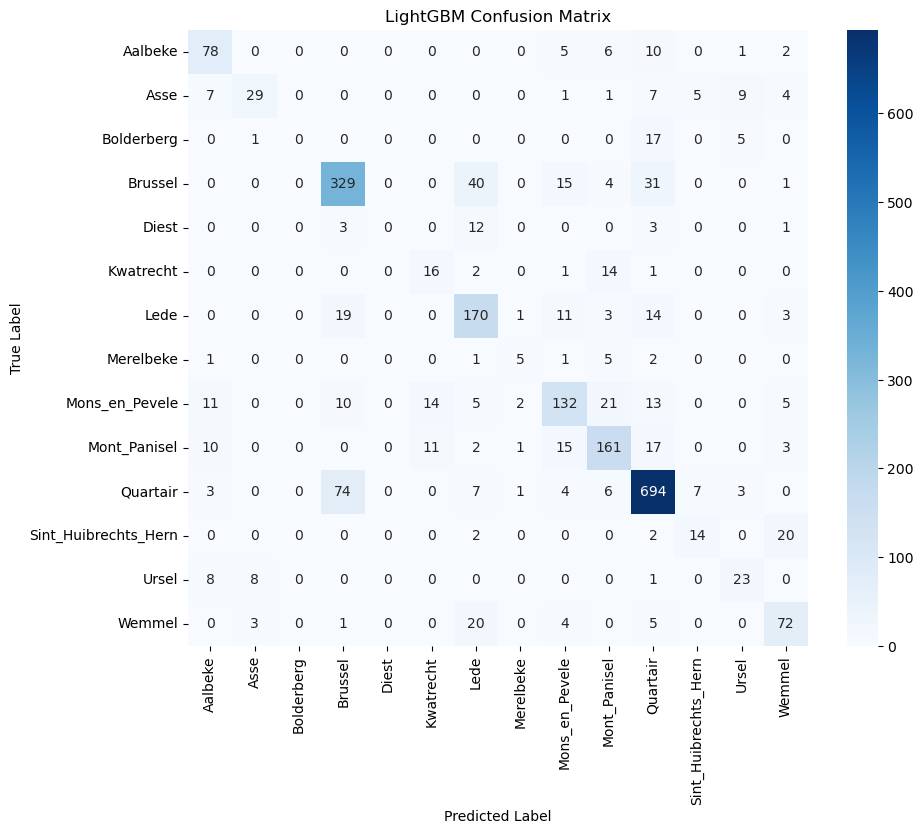

In [15]:
# LightGBM Evaluation
y_pred_lgbm = best_lgbm.predict(X_test)
print("LightGBM Classification Report:")
print(classification_report(y_test_enc, y_pred_lgbm, target_names=le.classes_))

plot_confusion_matrix(y_test_enc, y_pred_lgbm, le.classes_, title="LightGBM Confusion Matrix")

In [16]:
# Model Comparison & Export
results = {
    "xgb": {"model": best_xgb, "pred": y_pred_xgb},
    "rf": {"model": best_rf, "pred": y_pred_rf},
    "lgbm": {"model": best_lgbm, "pred": y_pred_lgbm}
}

summary = []
for name, res in results.items():
    acc = accuracy_score(y_test_enc, res["pred"])
    summary.append({"Model": name.upper(), "Test Accuracy": acc})

summary_df = pd.DataFrame(summary)
print(summary_df)

# Save Predictions
pred_folder = Path("../results/predictions_python_models")
pred_folder.mkdir(parents=True, exist_ok=True)

for name, res in results.items():
    pred_df = test_df[["sondering_id", "depth_bin", "lithostrat_id"]].copy()
    pred_df["predicted_label"] = le.inverse_transform(res["pred"])
    
    out_file = pred_folder / f"predictions_{name}_python.csv"
    pred_df.to_csv(out_file, index=False)
    print(f"Saved predictions to {out_file}")

  Model  Test Accuracy
0   XGB       0.751730
1    RF       0.766869
2  LGBM       0.745242
Saved predictions to ../results/predictions_python_models/predictions_xgb_python.csv
Saved predictions to ../results/predictions_python_models/predictions_rf_python.csv
Saved predictions to ../results/predictions_python_models/predictions_lgbm_python.csv


Preparing raw test data for full evaluation...
Raw test data shape (filtered): (74294, 20)

Confusion Matrix for XGB (Unbinned Data):


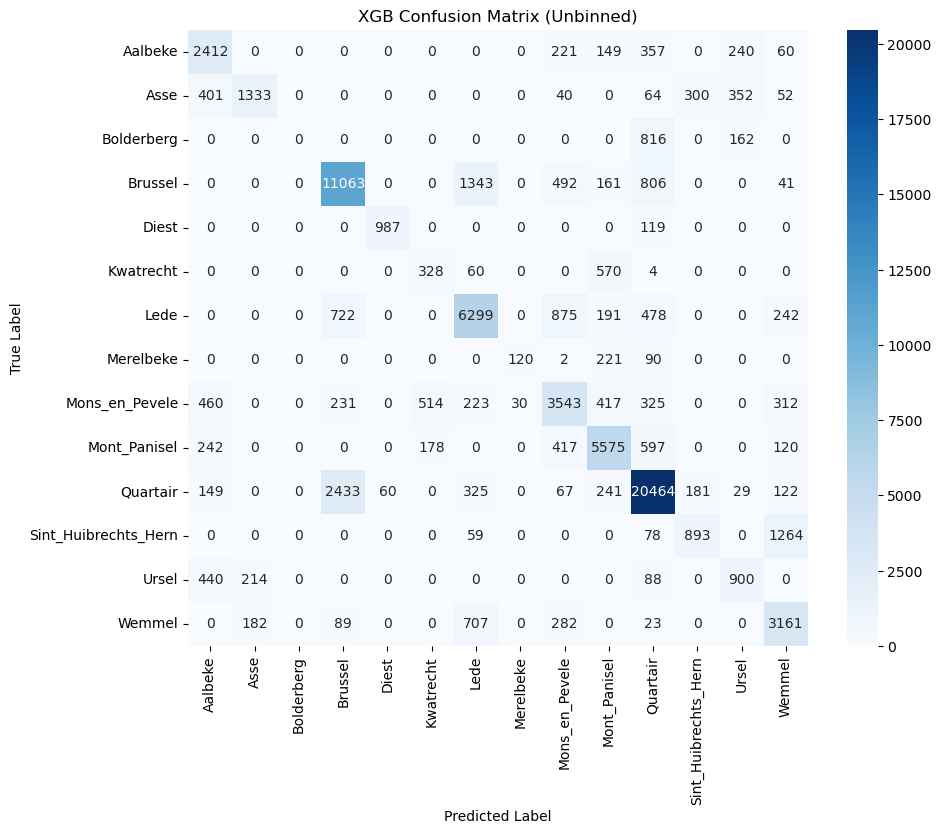


Confusion Matrix for RF (Unbinned Data):


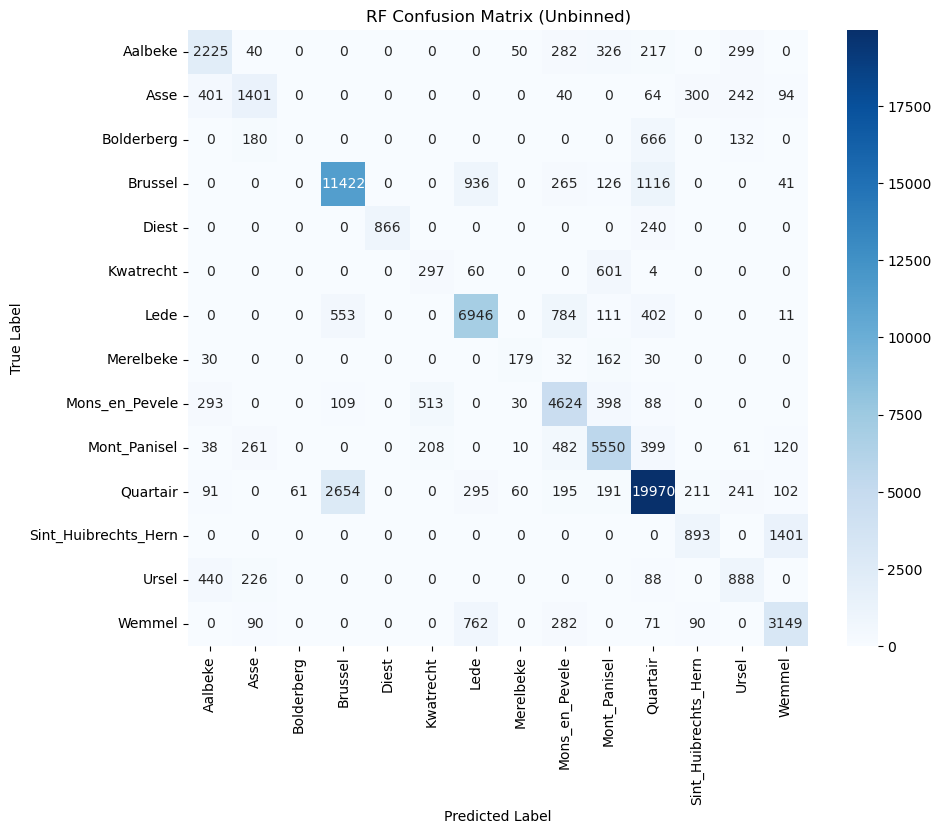


Confusion Matrix for LGBM (Unbinned Data):


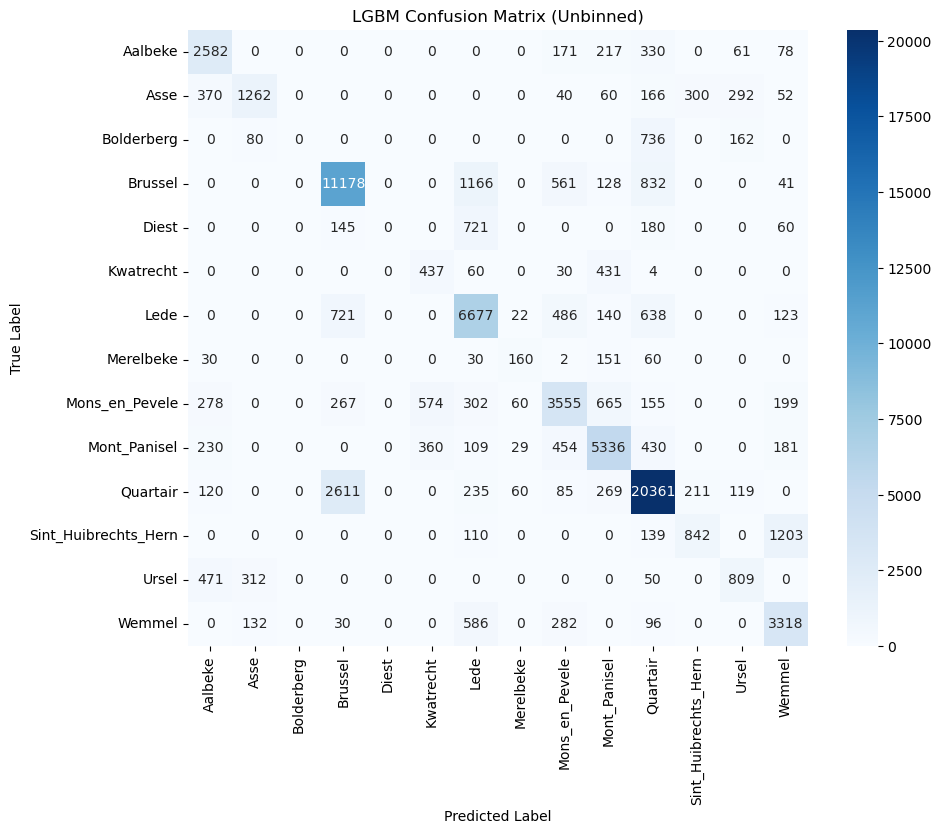


### Overall Performance on Full (Unbinned) CPT Data
  Model  Accuracy  Balanced Accuracy  F1 Score (Macro)     Kappa
0   XGB  0.733575           0.579502          0.591271  0.680428
1    RF  0.750694           0.594557          0.601386  0.701952
2  LGBM  0.726365           0.530061          0.528855  0.671324


In [17]:
# Full Dataset Evaluation (Unbinned)
from sklearn.metrics import f1_score, cohen_kappa_score, balanced_accuracy_score

print("Preparing raw test data for full evaluation...")
# 1. Get Raw Test Data
raw_test_df = cpt_data[cpt_data["sondering_id"].isin(test_ids)].copy()

# 2. Re-create Bins (Must match process_test_train logic exactly)
# process_test_train calculates bins based on the max depth of the input subset
max_depth = raw_test_df["diepte"].max()
bin_w = float(BIN_W)
bins = np.arange(0, max_depth + bin_w, bin_w)
if len(bins) < 2:
    bins = np.array([0, max_depth + bin_w])

# Apply binning
raw_test_df["depth_bin"] = pd.cut(raw_test_df["diepte"], bins=bins, include_lowest=True, ordered=True)

# 3. Filter Raw Data for Segments of Interest
# We only want to evaluate on the segments we trained on
raw_test_df = raw_test_df[raw_test_df["lithostrat_id"].isin(segments_oi) & (raw_test_df["lithostrat_id"] != "Onbekend")]

print(f"Raw test data shape (filtered): {raw_test_df.shape}")

# 4. Evaluate Each Model
full_metrics = []

for name, res in results.items():
    # Get predictions (at bin level)
    # We use test_df because that's the dataframe corresponding to the predictions
    bin_preds = test_df[["sondering_id", "depth_bin"]].copy()
    bin_preds["pred_class"] = le.inverse_transform(res["pred"])
    
    # Merge predictions onto raw data
    # Left join on raw data ensures we keep all raw measurements
    # This propagates the bin prediction to every raw measurement in that bin
    merged = pd.merge(raw_test_df, bin_preds, on=["sondering_id", "depth_bin"], how="left")
    ## write to results for debugging
    merged.to_csv(f"../results/predictions_python_models/debug_merged_{name}.csv", index=False)
    
    # Check for missing predictions
    n_missing = merged["pred_class"].isna().sum()
    if n_missing > 0:
        # This can happen if a bin exists in raw data but was filtered out of test_processed 
        # (e.g. due to missing features or NaN handling in aggregation)
        # For fair evaluation, we drop these rows as the model couldn't predict them
        merged = merged.dropna(subset=["pred_class"])
    
    # Calculate Metrics
    y_true = merged["lithostrat_id"]
    y_pred = merged["pred_class"]
    
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    kappa = cohen_kappa_score(y_true, y_pred)
    
    full_metrics.append({
        "Model": name.upper(),
        "Accuracy": acc,
        "Balanced Accuracy": bal_acc,
        "F1 Score (Macro)": f1,
        "Kappa": kappa
    })
    
    # Plot Confusion Matrix
    print(f"\nConfusion Matrix for {name.upper()} (Unbinned Data):")
    plot_confusion_matrix(y_true, y_pred, classes=le.classes_, title=f"{name.upper()} Confusion Matrix (Unbinned)")

# 5. Display Results
full_metrics_df = pd.DataFrame(full_metrics)
print("\n### Overall Performance on Full (Unbinned) CPT Data")
print(full_metrics_df)

In [18]:
import joblib

# Create results directory if it doesn't exist
model_dir = Path("../results/models")
model_dir.mkdir(parents=True, exist_ok=True)

# Save the best model (e.g., XGBoost)
joblib.dump(best_xgb, model_dir / "best_xgb_model.pkl")

# Save the Label Encoder
joblib.dump(le, model_dir / "label_encoder.pkl")

print("Model and Label Encoder saved to ../results/models/")

## save best rf
joblib.dump(best_rf, model_dir / "best_rf_model.pkl")

Model and Label Encoder saved to ../results/models/


['../results/models/best_rf_model.pkl']

Computing permutation importance using scoring='make_scorer(log_loss, greater_is_better=False, response_method='predict_proba', labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])'...

Top 15 Features by Permutation Importance:
                            feature  importance_mean  importance_std
169  diepte_mtaw_whole_trimmed_mean         0.033225        0.006950
61                       diepte_q90         0.032320        0.006201
143          diepte_mtaw_whole_mean         0.030661        0.006291
153           diepte_mtaw_whole_q10         0.030263        0.005548
27               diepte_mtaw_median         0.026958        0.005950
62                  diepte_mtaw_q90         0.026117        0.006641
49                           qc_q50         0.024623        0.001382
151           diepte_mtaw_whole_q01         0.023515        0.000742
159           diepte_mtaw_whole_q99         0.022036        0.000947
69                  diepte_mtaw_q99         0.020862        0.005671
157       

/tmp/ipykernel_51300/2005621608.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance_mean", y="feature", data=imp_df.head(50), palette="viridis")


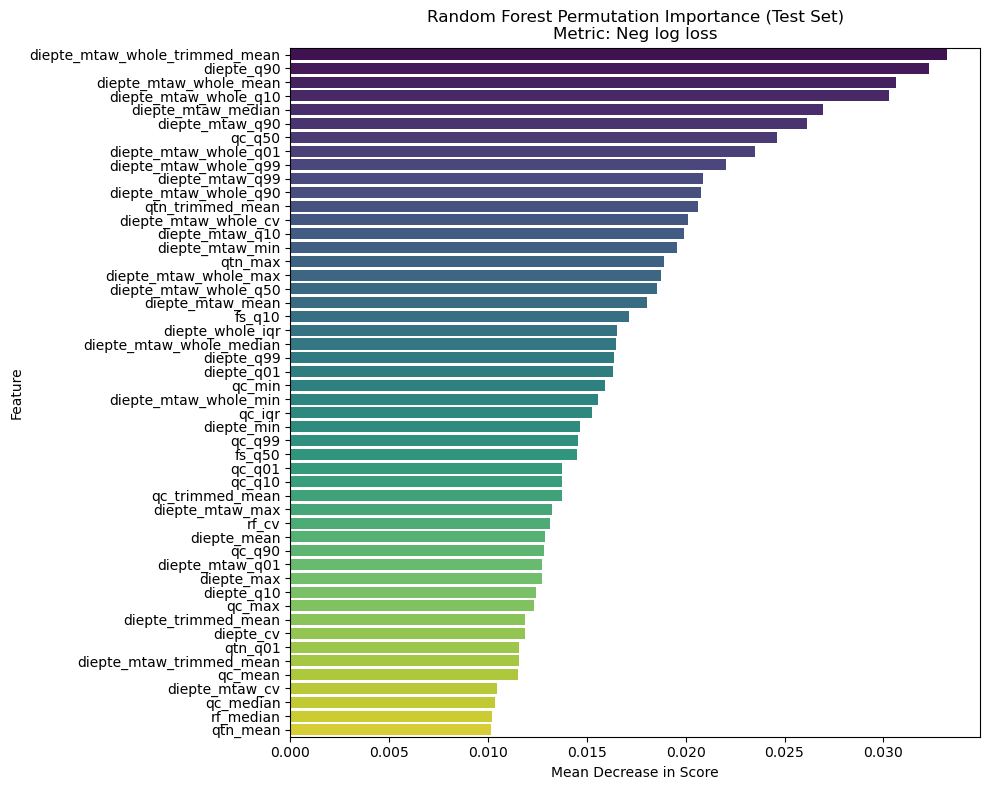

In [19]:

from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def compute_rf_permutation_importance(
    model,
    X_val,
    y_val,
    feature_names,
    le=None,
    n_repeats=5,
    random_state=42,
    scoring='accuracy'
):
    """
    Computes permutation importance for a fitted scikit-learn model (or pipeline).
    
    Args:
        model: Fitted estimator or pipeline (e.g., best_rf).
        X_val: Validation/Test features (DataFrame or numpy array).
        y_val: Validation/Test targets (encoded).
        feature_names: List of feature names.
        le: LabelEncoder (optional, passed for consistency/logging).
        n_repeats: Number of times to permute a feature.
        random_state: Seed for reproducibility.
        scoring: Scikit-learn scoring metric (default: 'accuracy'). 
                 'neg_log_loss' is also a good choice for probabilistic models.
    
    Returns:
        pd.DataFrame: Feature importance sorted by importance_mean.
    """
    
    print(f"Computing permutation importance using scoring='{scoring}'...")
    
    # Compute permutation importance
    # n_jobs=-1 uses all available processors
    result = permutation_importance(
        model,
        X_val,
        y_val,
        n_repeats=n_repeats,
        random_state=random_state,
        n_jobs= 10,
        scoring=scoring
    )

    # Create DataFrame
    # For standard sklearn metrics (like accuracy or neg_log_loss), 
    # a positive importance_mean indicates the feature is important 
    # (shuffling it caused the score to drop).
    imp_df = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }).sort_values("importance_mean", ascending=False)

    return imp_df

# --- Execute Feature Importance ---

# Calculate importance using the Test set
imp_df = compute_rf_permutation_importance(
    model=best_rf,
    X_val=X_test,
    y_val=y_test_enc,
    feature_names=feature_cols,
    le=le,
    n_repeats=5,       # 5 repeats is usually sufficient for stable results
    random_state=SEED,
    scoring=custom_log_loss
)

print("\nTop 15 Features by Permutation Importance:")
print(imp_df.head(15))

# --- Plotting ---
plt.figure(figsize=(10, 8))
sns.barplot(x="importance_mean", y="feature", data=imp_df.head(50), palette="viridis")
plt.title(f"Random Forest Permutation Importance (Test Set)\nMetric: Neg log loss")
plt.xlabel("Mean Decrease in Score")
plt.ylabel("Feature")
plt.tight_layout()

In [20]:
# save csv to results
imp_df.to_csv("../results/rf_permutation_importance.csv", index=False)
imp_df.head(50)


,feature,importance_mean,importance_std
169,diepte_mtaw_whole_trimmed_mean,0.033225,0.006950
61,diepte_q90,0.032320,0.006201
143,diepte_mtaw_whole_mean,0.030661,0.006291
153,diepte_mtaw_whole_q10,0.030263,0.005548
27,diepte_mtaw_median,0.026958,0.005950
62,diepte_mtaw_q90,0.026117,0.006641
49,qc_q50,0.024623,0.001382
151,diepte_mtaw_whole_q01,0.023515,0.000742
159,diepte_mtaw_whole_q99,0.022036,0.000947
69,diepte_mtaw_q99,0.020862,0.005671


/tmp/ipykernel_51300/2730947080.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance_mean", y="feature", data=imp_df.head(50), palette="viridis")


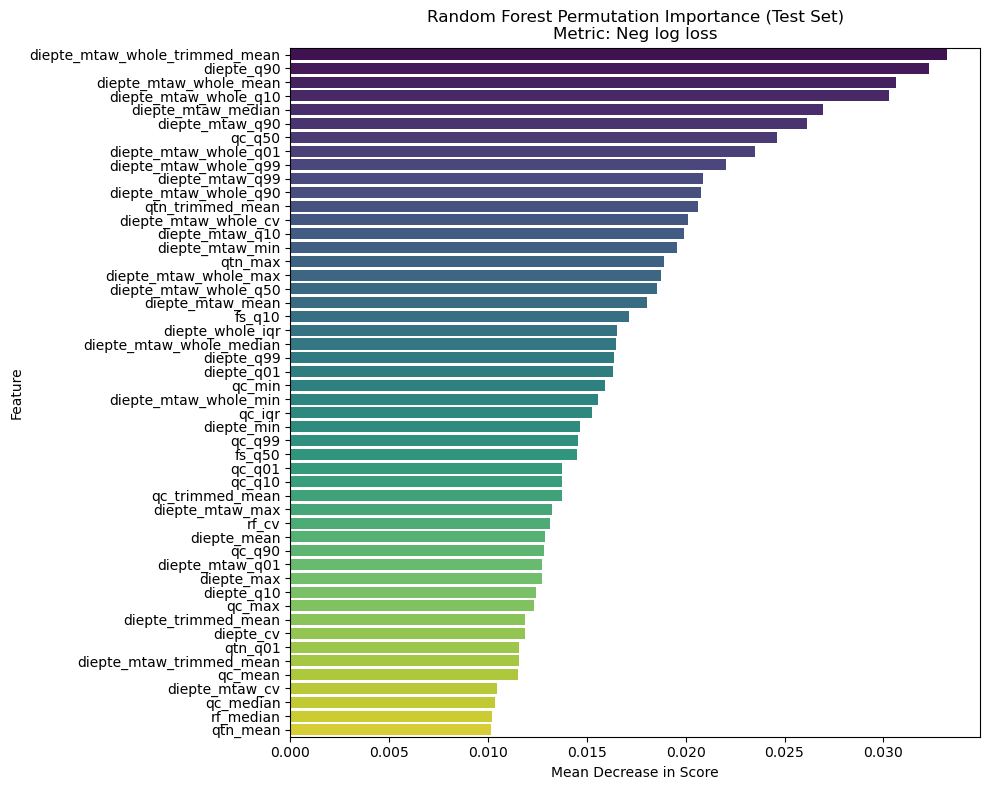

In [24]:
# save plot
plt.figure(figsize=(10, 8))
sns.barplot(x="importance_mean", y="feature", data=imp_df.head(50), palette="viridis")
plt.title(f"Random Forest Permutation Importance (Test Set)\nMetric: Neg log loss")
plt.xlabel("Mean Decrease in Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("../results/rf_permutation_importance.png", dpi=500)
plt.show()